[CDC Firearm Mortality](https://www.cdc.gov/nchs/state-stats/deaths/firearms.html?CDC_AAref_Val=https://www.cdc.gov/nchs/pressroom/sosmap/firearm_mortality/firearm.htm)

In [159]:
import requests
import pandas as pd
import numpy as np

BASE = "https://data.cdc.gov/resource/fpsi-y8tj.json"

def fetch_firearm_state(period="2023", intent="FA_Deaths"):
    params = {
        "$select": "name as state, geoid, intent, period, rate, count_sup, data_as_of",
        "$where": f"period='{period}' AND intent='{intent}'",
        "$order": "state",
        "$limit": 50000
    }
    r = requests.get(BASE, params=params, timeout=60)
    r.raise_for_status()
    df = pd.DataFrame(r.json())
    if not df.empty and "rate" in df.columns:
        df["rate"] = pd.to_numeric(df["rate"], errors="coerce")
    return df

# All firearm deaths by state for 2023
df_all = fetch_firearm_state(period="2023", intent="FA_Deaths")
print("All firearm deaths, 2023:")
print(df_all.head(), "\nRows:", len(df_all))

# Obtain Homicide and Suicde Rates
df_homicide = fetch_firearm_state(period="2023", intent="FA_Homicide")
df_suicide = fetch_firearm_state(period="2023", intent="FA_Suicide")

# Combinne each query
combined = (
    df_all.merge(df_homicide[["state","rate"]].rename(columns={"rate":"fa_homicide_rate"}), on="state", how="left")
          .merge(df_suicide[["state","rate"]].rename(columns={"rate":"fa_suicide_rate"}), on="state", how="left")
)
print("\nCombined firearm mortality by state (all, homicide, suicide):")
print(combined.head())

combined.to_csv("firearm_mortality_by_state_2023.csv", index=False)


All firearm deaths, 2023:
        state geoid     intent period  rate count_sup               data_as_of
0     Alabama    01  FA_Deaths   2023  25.3      1292  2025-09-05T00:00:00.000
1      Alaska    02  FA_Deaths   2023  24.0       176  2025-09-05T00:00:00.000
2     Arizona    04  FA_Deaths   2023  19.1      1419  2025-09-05T00:00:00.000
3    Arkansas    05  FA_Deaths   2023  21.9       671  2025-09-05T00:00:00.000
4  California    06  FA_Deaths   2023   8.2      3209  2025-09-05T00:00:00.000 
Rows: 51

Combined firearm mortality by state (all, homicide, suicide):
        state geoid     intent period  rate count_sup  \
0     Alabama    01  FA_Deaths   2023  25.3      1292   
1      Alaska    02  FA_Deaths   2023  24.0       176   
2     Arizona    04  FA_Deaths   2023  19.1      1419   
3    Arkansas    05  FA_Deaths   2023  21.9       671   
4  California    06  FA_Deaths   2023   8.2      3209   

                data_as_of  fa_homicide_rate  fa_suicide_rate  
0  2025-09-05T00:00:

[World Population Review](https://worldpopulationreview.com/state-rankings/strictest-gun-laws-by-state)

In [160]:
df_laws = pd.read_csv("strictest-gun-laws-by-state-2025.csv")

In [161]:
# If you have different spellings, normalize IN PLACE without creating a key column
combined["state"] = combined["state"].str.strip().replace({"Washington, D.C.": "District of Columbia"})
df_laws["state"] = df_laws["state"].str.strip().replace({"Washington, D.C.": "District of Columbia"})

# Keep only the grade column from df_laws, then merge on 'state'
laws_keep = df_laws[["state", "StrictestGunLawsGiffordGrade_2024"]].drop_duplicates("state")

merged = combined.merge(laws_keep, on="state", how="left")

# Optional: see which states did not match
missing = sorted(set(merged["state"]) - set(laws_keep["state"]))
if missing:
    print("No grade found for:", missing)

merged.head()

No grade found for: ['District of Columbia']


,state,geoid,intent,period,rate,count_sup,data_as_of,fa_homicide_rate,fa_suicide_rate,StrictestGunLawsGiffordGrade_2024
0,Alabama,01,FA_Deaths,2023,25.3,1292,2025-09-05T00:00:00.000,12.4,12.1,F
1,Alaska,02,FA_Deaths,2023,24.0,176,2025-09-05T00:00:00.000,6.4,16.4,F
2,Arizona,04,FA_Deaths,2023,19.1,1419,2025-09-05T00:00:00.000,5.5,12.8,F
3,Arkansas,05,FA_Deaths,2023,21.9,671,2025-09-05T00:00:00.000,8.6,12.8,F
4,California,06,FA_Deaths,2023,8.2,3209,2025-09-05T00:00:00.000,3.7,4.2,A


In [162]:
# normalize and extract a clean letter grade like A, A-, A+, B, B+, B-, ..., F
g = (
    merged["StrictestGunLawsGiffordGrade_2024"]
      .astype(str).str.upper().str.strip()
      .str.extract(r'(A\+|A\-|A|B\+|B\-|B|C\+|C\-|C|D\+|D\-|D|F)')[0]
)

grade_to_likert = {
    "A+": "Very Strong", "A": "Very Strong", "A-": "Very Strong",
    "B+": "Strong", "B": "Strong", "B-": "Strong",
    "C+": "Neutral", "C": "Neutral", "C-": "Neutral",
    "D+": "Weak", "D": "Weak", "D-": "Weak",
    "F": "Very Weak",
}

merged["StrictestGunLawsGiffordGrade_2024"] = g.map(grade_to_likert)

likert_order = ["Very Weak", "Weak", "Neutral", "Strong", "Very Strong"]
cat = pd.CategoricalDtype(categories=likert_order, ordered=True)
merged["StrictestGunLawsGiffordGrade_2024"] = merged["StrictestGunLawsGiffordGrade_2024"].astype(cat)

unmapped = merged[merged["StrictestGunLawsGiffordGrade_2024"].isna()]
if not unmapped.empty:
    print("Unmapped grades found in StrictestGunLawsGiffordGrade_2024:")
    print(unmapped[["state"]].assign(original=merged["StrictestGunLawsGiffordGrade_2024"]))

In [163]:
merged = merged.rename(columns={'StrictestGunLawsGiffordGrade_2024':'gun_laws'})

In [164]:
merged.to_csv("gun_data.csv")

In [165]:
merged

,state,geoid,intent,period,rate,count_sup,data_as_of,fa_homicide_rate,fa_suicide_rate,gun_laws
0,Alabama,01,FA_Deaths,2023,25.3,1292,2025-09-05T00:00:00.000,12.4,12.1,Very Weak
1,Alaska,02,FA_Deaths,2023,24.0,176,2025-09-05T00:00:00.000,6.4,16.4,Very Weak
2,Arizona,04,FA_Deaths,2023,19.1,1419,2025-09-05T00:00:00.000,5.5,12.8,Very Weak
3,Arkansas,05,FA_Deaths,2023,21.9,671,2025-09-05T00:00:00.000,8.6,12.8,Very Weak
4,California,06,FA_Deaths,2023,8.2,3209,2025-09-05T00:00:00.000,3.7,4.2,Very Strong
5,Colorado,08,FA_Deaths,2023,17.3,1019,2025-09-05T00:00:00.000,4.4,12.3,Very Strong
6,Connecticut,09,FA_Deaths,2023,6.2,225,2025-09-05T00:00:00.000,2.9,3.1,Very Strong
7,Delaware,10,FA_Deaths,2023,12.0,124,2025-09-05T00:00:00.000,4.2,7.4,Very Strong
8,District of Columbia,11,FA_Deaths,2023,33.1,225,2025-09-05T00:00:00.000,31.1,1.5,Very Strong
9,Florida,12,FA_Deaths,2023,14.4,3253,2025-09-05T00:00:00.000,4.7,9.3,Neutral


In [166]:
import plotly.express as px

# state name to USPS code
name_to_code = {
    'Alabama':'AL','Alaska':'AK','Arizona':'AZ','Arkansas':'AR','California':'CA','Colorado':'CO',
    'Connecticut':'CT','Delaware':'DE','District of Columbia':'DC','Florida':'FL','Georgia':'GA',
    'Hawaii':'HI','Idaho':'ID','Illinois':'IL','Indiana':'IN','Iowa':'IA','Kansas':'KS','Kentucky':'KY',
    'Louisiana':'LA','Maine':'ME','Maryland':'MD','Massachusetts':'MA','Michigan':'MI','Minnesota':'MN',
    'Mississippi':'MS','Missouri':'MO','Montana':'MT','Nebraska':'NE','Nevada':'NV','New Hampshire':'NH',
    'New Jersey':'NJ','New Mexico':'NM','New York':'NY','North Carolina':'NC','North Dakota':'ND',
    'Ohio':'OH','Oklahoma':'OK','Oregon':'OR','Pennsylvania':'PA','Rhode Island':'RI','South Carolina':'SC',
    'South Dakota':'SD','Tennessee':'TN','Texas':'TX','Utah':'UT','Vermont':'VT','Virginia':'VA',
    'Washington':'WA','West Virginia':'WV','Wisconsin':'WI','Wyoming':'WY'
}

merged["state_code"] = merged["state"].map(name_to_code)
category_orders = {
    "gun_laws": ["Very Weak", "Weak", "Neutral", "Strong", "Very Strong"]
}


fig = px.choropleth(
    merged,
    locations="state_code",
    locationmode="USA-states",
    color="rate",
    facet_col="gun_laws",
    facet_col_wrap=2,
    category_orders=category_orders,
    scope="usa",
    color_continuous_scale="RdBu_r",
    title="Firearm Fatality Rate by Gun Law Strength (2023)"
)
fig.show()

In [167]:
import pandas as pd
import plotly.express as px

# 0) Start from your dataframe
df = merged.copy()

# 1) Make sure rate is numeric and build a Likert column from gun_laws
df["rate"] = pd.to_numeric(df["rate"], errors="coerce")

# If you already have a likert column, skip this assignment
df["likert"] = df["gun_laws"]

# 2) Define ordered Likert levels so the legend sorts logically
order = ["Very Weak", "Weak", "Neutral", "Strong", "Very Strong"]
df["Gun Laws"] = pd.Categorical(df["likert"], categories=order, ordered=True)

# 3) Tiled US grid positions
nyt_states = pd.read_csv("https://raw.githubusercontent.com/kristw/gridmap-layout-usa/refs/heads/master/dist/gridmap-layout-usa.csv")

# 4) Merge by state code
df2 = df.merge(nyt_states, left_on="state_code", right_on="key", how="left")

df2["y"] = df2["y"] * -1

# 5) Safety check for any states missing a grid placement
missing = df2[df2["x"].isna()]
if not missing.empty:
    print("Warning: missing grid placement for:", sorted(missing["state_code"].unique().tolist()))
    
likert_colors = ["#AEC6CF", "#BFD4DB", "#EBEBEB", "#FFDFBF", "#FFB347"]

# 7) Build the figure
fig = px.scatter(
    df2, x="x", y="y",
    color="Gun Laws",
    hover_name="state",
    hover_data={
        "Gun Death Rate": df2["rate"],
        "Homicide Rate": df2["fa_homicide_rate"],
        "Suicide": df2["fa_suicide_rate"],
        "gun_laws": True,
        "x": False, "y": False, "x": False, "y": False
    },
    category_orders={"Gun Laws": order},
    color_discrete_sequence=likert_colors
)

# Square tiles
fig.update_traces(marker=dict(symbol="square", size=40, line=dict(color="white", width=1)))

# 8) Add tile labels: state code and rate
for _, r in df2.dropna(subset=["x","y"]).iterrows():
    fig.add_annotation(
        x=r["x"], y=r["y"],
        text=f"{r['state_code']}<br>{r['rate']:.1f}" if pd.notna(r["rate"]) else f"{r['state_code']}",
        showarrow=False,
        font=dict(size=10)
    )

# 9) Style
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False, scaleanchor="x", scaleratio=1)
fig.update_layout(
    plot_bgcolor="white",
    margin=dict(l=5, r=5, t=5, b=5)
)

fig.show()



/var/folders/c3/xzrx9_vx26s_2c8n5tm5sggm0000gn/T/ipykernel_46193/3165424890.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




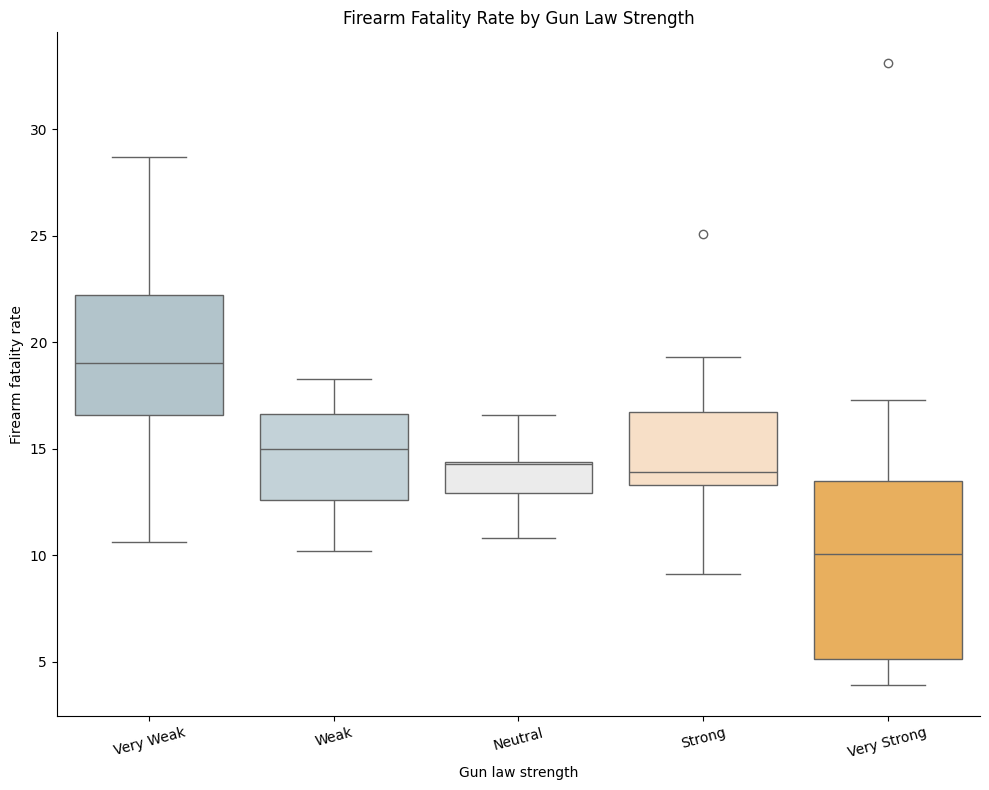

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

order = ["Very Weak", "Weak", "Neutral", "Strong", "Very Strong"]
palette = sns.color_palette(likert_colors, n_colors=len(order))  # blue → red

plt.figure(figsize=(10, 8))
sns.boxplot(
    data=merged,
    x="gun_laws",
    y="rate",
    order=order,
    palette=palette
)
sns.despine()
plt.xlabel("Gun law strength")
plt.ylabel("Firearm fatality rate")
plt.title("Firearm Fatality Rate by Gun Law Strength")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
